# 1. 价值选股

低PE/PB/PS/PCF

In [1]:
    from fxdayu_data import DataAPI
    from datetime import datetime
    import tushare as ts
    import numpy as np
    # from sklearn import preprocessing
    import matplotlib.pyplot as plt
    import pandas as pd

    DataAPI.set_file('D:/PycharmProjects/Quant_Alpha/Data_Manager/Valuation_Selection/config.py')

    def coder(code):
        if code.startswith('6'):
            return code + '.XSHG'
        elif code.startswith('0') or code.startswith('3'):
            return code + '.XSHE'
        else:
            return code


    name = ts.get_hs300s()
    name_list = list(name.code)
    codes = tuple(map(coder, name_list))
    print(codes)

[Errno 2] No such file or directory: 'config.py'
('603993.XSHG', '600588.XSHG', '000069.XSHE', '600637.XSHG', '601958.XSHG', '000559.XSHE', '600498.XSHG', '600008.XSHG', '600549.XSHG', '000725.XSHE', '600153.XSHG', '600871.XSHG', '000938.XSHE', '002475.XSHE', '600276.XSHG', '600309.XSHG', '601901.XSHG', '600118.XSHG', '000783.XSHE', '002008.XSHE', '002415.XSHE', '002027.XSHE', '600685.XSHG', '601318.XSHG', '000630.XSHE', '300072.XSHE', '000826.XSHE', '002174.XSHE', '600150.XSHG', '600703.XSHG', '300015.XSHE', '000738.XSHE', '601169.XSHG', '600038.XSHG', '600893.XSHG', '002074.XSHE', '000728.XSHE', '600373.XSHG', '300124.XSHE', '002450.XSHE', '000060.XSHE', '000063.XSHE', '600372.XSHG', '600061.XSHG', '000768.XSHE', '600415.XSHG', '000712.XSHE', '000568.XSHE', '601928.XSHG', '000156.XSHE', '601601.XSHG', '000413.XSHE', '601006.XSHG', '600111.XSHG', '600109.XSHG', '601127.XSHG', '600019.XSHG', '002292.XSHE', '600482.XSHG', '601933.XSHG', '601288.XSHG', '000627.XSHE', '600015.XSHG', '6019

In [2]:
PN = DataAPI.factor(codes, ('PE', 'PB', 'PS', 'PCF', 'close'), start=datetime(2013, 1, 1))
prices = PN.minor_xs('close')

print PN
print prices

<class 'pandas.core.panel.Panel'>
Dimensions: 300 (items) x 1077 (major_axis) x 5 (minor_axis)
Items axis: 000001.XSHE to 603993.XSHG
Major_axis axis: 2013-01-04 15:00:00 to 2017-06-13 15:00:00
Minor_axis axis: PB to close
                     000001.XSHE  000002.XSHE  000008.XSHE  000009.XSHE  \
datetime                                                                  
2013-01-04 15:00:00        5.521          NaN        1.219        4.641   
2013-01-07 15:00:00        5.628          NaN        1.227        4.689   
2013-01-08 15:00:00        5.525          NaN        1.246        4.667   
2013-01-09 15:00:00        5.476          NaN        1.265        4.747   
2013-01-10 15:00:00        5.480          NaN        1.273        4.747   
2013-01-11 15:00:00        5.366          NaN        1.247        4.577   
2013-01-14 15:00:00        5.901          NaN        1.269        4.710   
2013-01-15 15:00:00        6.081          NaN        1.269        4.869   
2013-01-16 15:00:00        

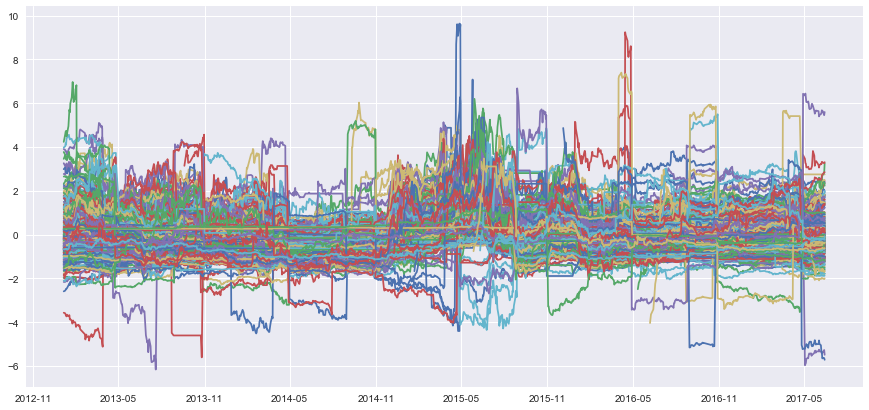

In [19]:
def winsorize(df):
    q = df.quantile([0.025, 0.975])
    if isinstance(q, pd.Series) and len(q) == 2:
        df[df < q.iloc[0]] = q.iloc[0]
        df[df > q.iloc[1]] = q.iloc[1]
    return df

def standardize(df):
    df_std = df.std()
    df_mean = df.mean()
    return (df - df_mean) / df_std

S_PE = standardize(winsorize(PN.minor_xs('PE')))
S_PB = standardize(winsorize(PN.minor_xs('PB')))
S_PS = standardize(winsorize(PN.minor_xs('PS')))
S_PCF = standardize(winsorize(PN.minor_xs('PCF')))
fig = plt.figure(figsize=(15, 7))
plt.plot(S_PE)
plt.show()

In [4]:
S = -(2*S_PE+2*S_PB+2*S_PS+2*S_PCF)
factor = S.stack()

print(factor)

datetime                        
2013-01-04 15:00:00  000001.XSHE     1.264161
                     000002.XSHE    -1.590055
                     000008.XSHE    -6.092451
                     000009.XSHE     3.055621
                     000027.XSHE     4.511391
                     000039.XSHE     3.499730
                     000060.XSHE     3.076884
                     000061.XSHE     0.921057
                     000063.XSHE    10.052041
                     000069.XSHE   -15.872640
                     000100.XSHE    -0.649205
                     000156.XSHE     8.243986
                     000157.XSHE    -6.234476
                     000338.XSHE   -14.129727
                     000402.XSHE    -4.291790
                     000413.XSHE     0.022445
                     000415.XSHE    -0.960916
                     000423.XSHE    -8.603386
                     000425.XSHE     1.172094
                     000503.XSHE     7.056224
                     000538.XSHE    -4.369762
 

In [5]:
import alphalens

factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor, prices, quantiles=5)
cond = factor_data['factor_quantile'] == 5
save = factor_data[cond]
s = pd.Series(True, index=save.index)
s = s.unstack()
s[s != True] = False
# s.to_excel('Value_Selection.xlsx')
print(s)

asset               000001.XSHE 000002.XSHE 000008.XSHE 000009.XSHE  \
date                                                                  
2013-01-04 15:00:00       False       False       False       False   
2013-01-07 15:00:00       False       False       False       False   
2013-01-08 15:00:00       False       False       False       False   
2013-01-09 15:00:00       False       False       False       False   
2013-01-10 15:00:00       False       False       False       False   
2013-01-11 15:00:00       False       False       False       False   
2013-01-14 15:00:00       False       False       False       False   
2013-01-15 15:00:00       False       False       False       False   
2013-01-16 15:00:00       False       False       False       False   
2013-01-17 15:00:00       False       False       False       False   
2013-01-18 15:00:00       False       False       False       False   
2013-01-21 15:00:00       False       False       False       False   
2013-0

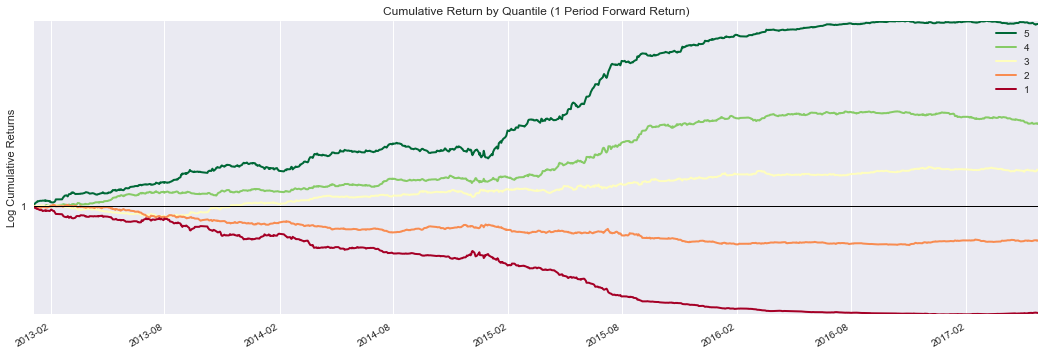

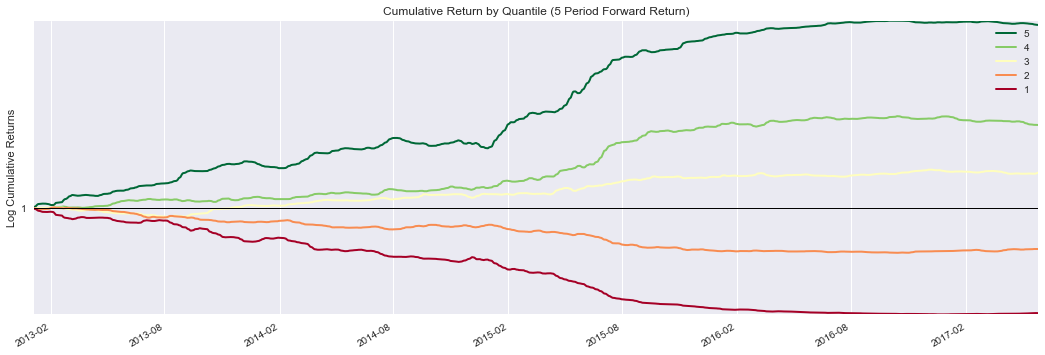

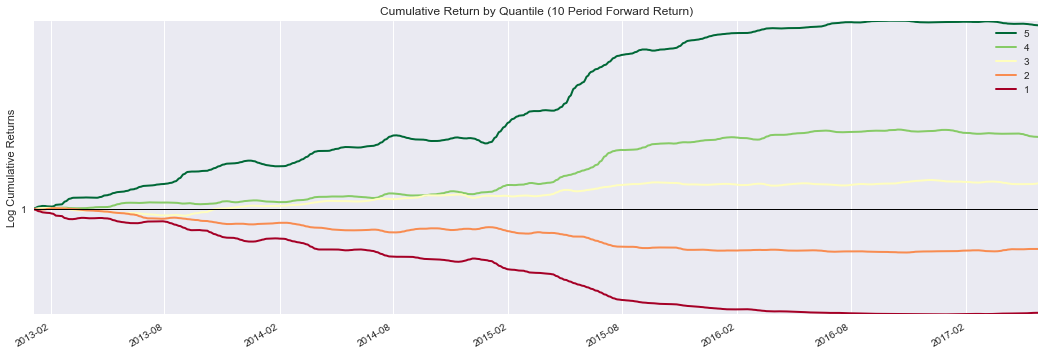

In [16]:
mean_return_by_q, std_err_by_q = alphalens.performance.mean_return_by_quantile(factor_data, by_date=True)
# print(mean_return_by_q).head()
# print(std_err_by_q).head()

alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 1)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 5)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 10)
plt.show()

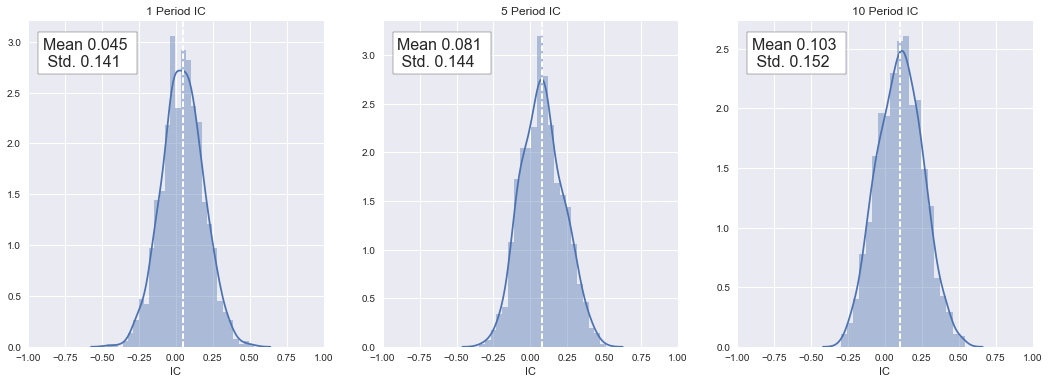

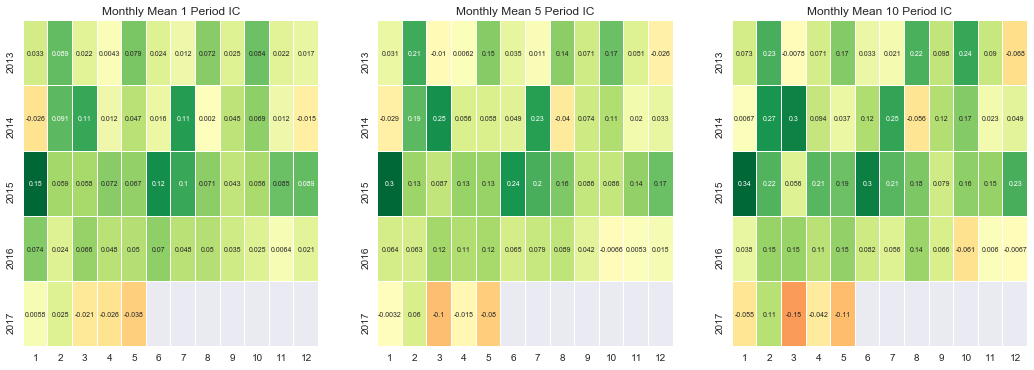

In [17]:
ic = alphalens.performance.factor_information_coefficient(factor_data)
# print ic
alphalens.plotting.plot_ic_hist(ic)
mean_monthly_ic = alphalens.performance.mean_information_coefficient(factor_data, by_time='M')
# print mean_monthly_ic.mean()
alphalens.plotting.plot_monthly_ic_heatmap(mean_monthly_ic)
plt.show()